In [1]:
import os
import re
import sys

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'PVT-thermal-performance-model')))
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'PVT-thermal-performance-model', 'CFD')))
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'RD-systems-and-test-benches')))
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'PVT-PL-model')))
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'PVT-PL-model', 'ansys')))

import numpy as np
import pandas as pd
import openpyxl

from scipy import interpolate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.io as pio
# import plotly 
# plotly.io.kaleido.scope.mathjax= None

from tqdm import tqdm

from CoolProp.CoolProp import PropsSI

# Own modules

import jou_gen as jg
import hx_hydraulic as hxhy
import model_fsolve_v2 as modf2

import utils.conversion as conversion

In [2]:
import repo_config as rconfig

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import matplotlib_inline

import scienceplots

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.style.use(['science'])

def to_percent(y, _):
    return f"{y * 100:.0f}\%"

# colors = ['olive', 'green', 'blue', 'orange', 'red', 'grey','yellow','bordeaux']
colors = ['olive','orange','blue','red','green','grey']
colors70 = [rconfig.get_hex_code(color, 70) for color in colors]
colors = [rconfig.get_hex_code(color, 100) for color in colors]
linestyles = ['-', '--',  (5, (10, 3)), '-.', (0, (1, 1)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5)), (0, (3, 5, 1, 5))]
markers = ['o', 's', 'd', 'X', 'v', '^', 'P', 'H']

In [3]:
def sort_key(path):
    match = re.search(r'case(\d+)', path)
    if match:
        return (path.split('case')[0], int(match.group(1)))
    return (path, 0)

In [4]:
# abaque_folder = r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\ANSYS Fluent Projects\Hydraulics\NUMAIRO_V4.5_motif\SimulationResults\abaque0_laminar_try0'
abaque_folder = r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\ANSYS Fluent Projects\Hydraulics\NUMAIRO_motif\SimulationResults\V4.5_1MPE_M2\abaque300_laminar_try0'

cases_paths = [f.path for f in os.scandir(abaque_folder) if f.is_dir()]
cases_paths.sort(key=sort_key)
# cases_paths

In [5]:
Vdot = 500

In [ ]:
T_op = 23 + 273.15
p_op = 101325

rho_op = PropsSI('D', 'T', T_op, 'P', p_op, 'INCOMP::MPG[0.4]')
rho_op

In [ ]:
list_dict = []

for i, case_path in tqdm(enumerate(cases_paths), total=len(cases_paths)):

    sp_df = pd.read_csv(os.path.join(cases_paths[i], 'sp_report.csv'), sep=',')
    mdot_df = pd.read_csv(os.path.join(cases_paths[i], 'mdot_report.csv'), sep=',')

    list_dict.append(
                {
                'case_name' : f'case{i}',
                'mdot_max' : mdot_df.loc[mdot_df['Component'] == 'distrib_inlet', 'mdot'].values[0] + mdot_df.loc[mdot_df['Component'] == 'coll_inlet', 'mdot'].values[0],
                'Vdot_max' : ((mdot_df.loc[mdot_df['Component'] == 'distrib_inlet', 'mdot'].values[0] + mdot_df.loc[mdot_df['Component'] == 'coll_inlet', 'mdot'].values[0])/rho_op) * 3.6e6,
                'mdot_distrib_inlet' : mdot_df.loc[mdot_df['Component'] == 'distrib_inlet', 'mdot'].values[0],
                'mdot_distrib_outlet' : - mdot_df.loc[mdot_df['Component'] == 'distrib_outlet', 'mdot'].values[0],
                'mdot_coll_inlet' : mdot_df.loc[mdot_df['Component'] == 'coll_inlet', 'mdot'].values[0],
                'mdot_coll_outlet' : - mdot_df.loc[mdot_df['Component'] == 'coll_outlet', 'mdot'].values[0],
                'alpha' : 0.,
                'beta' : mdot_df.loc[mdot_df['Component'] == 'distrib_inlet', 'mdot'].values[0] / (mdot_df.loc[mdot_df['Component'] == 'distrib_inlet', 'mdot'].values[0] + mdot_df.loc[mdot_df['Component'] == 'coll_inlet', 'mdot'].values[0]),
                'P_coll_inlet' : sp_df.loc[sp_df['Component'] == 'coll_inlet', 'sp'].values[0],
                'P_coll_outlet' : sp_df.loc[sp_df['Component'] == 'coll_outlet', 'sp'].values[0],
                'P_distrib_inlet' : sp_df.loc[sp_df['Component'] == 'distrib_inlet', 'sp'].values[0],
                'P_distrib_outlet' : sp_df.loc[sp_df['Component'] == 'distrib_outlet', 'sp'].values[0]
                  }
                  )
    
abaque_df = pd.DataFrame(list_dict)
abaque_df['alpha'] = 1 - (abaque_df['mdot_distrib_outlet'] / abaque_df['mdot_distrib_inlet'])
abaque_df['DPd'] = abaque_df['P_distrib_inlet'] - abaque_df['P_distrib_outlet']
abaque_df['DPc'] = abaque_df['P_coll_inlet'] - abaque_df['P_coll_outlet']
abaque_df['DPdc'] = abaque_df['P_distrib_inlet'] - abaque_df['P_coll_inlet']
abaque_df['Qin_d'] = abaque_df['mdot_distrib_inlet'] / rho_op # m3/s kg/s / kg/m3
abaque_df

### Test sur 1 cas STRESSS

In [8]:
def create_interpolating_function(df, X1_name, X2_name, Y_name, degree, include_bias):

    # Generate polynomial features up to the third degree
    X_columns = df[[X1_name, X2_name]]
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
    X_poly = poly.fit_transform(X_columns)
    # Fit the model
    model = LinearRegression()
    model.fit(X_poly, df[Y_name])
    # Coefficients
    coefficients = model.coef_
    intercept = model.intercept_

    def interpolate_Y(X1_value, X2_value):
        # Combine the input values into the same structure as the model expects
        X_input = np.array([[X1_value, X2_value]])
        # Transform the input values to polynomial features
        X_input_poly = poly.transform(X_input)
        # Predict the output using the fitted model
        Y_pred = model.predict(X_input_poly)
        return Y_pred[0]
    
    return interpolate_Y

In [9]:
# df_abaque = pd.read_excel(r"G:\Drive partagés\Cercle Hard\Notion\PRJ-1088 - CFD pour la caractérisation hydraulique d’un échangeur à mini-canaux\CFD_V4.5_1MPE_woch\AbaqueCFD_1MPE_woch.xlsx")

N=1

df_fil = abaque_df
X1_name = 'alpha'
X2_name = 'beta'
X_columns = df_fil[[X1_name, X2_name]]
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_columns)

# model_d = LinearRegression()
# model_d.fit(X_poly, df_fil['DPd'])
# model_c = LinearRegression()
# model_c.fit(X_poly, df_fil['DPc'])
# model_dc = LinearRegression()
# model_dc.fit(X_poly, df_fil['DPdc'])

# def DPd(Qin, alpha):
#     point = np.array([[Qin*3600000/Vdot, alpha]])
#     X_poly = poly.fit_transform(point)
#     return model_d.predict(X_poly)[0]
# def DPc(Qin, alpha):
#     point = np.array([[Qin*3600000/Vdot, alpha]])
#     X_poly = poly.fit_transform(point)
#     return model_c.predict(X_poly)[0]
# def DPdc(Qin, alpha):
#     point = np.array([[Qin*3600000/Vdot, alpha]])
#     X_poly = poly.fit_transform(point)
#     return - model_dc.predict(X_poly)[0]

DPd, DPc, DPdc = modf2.transfer_func(df_fil, deg_a = 2, deg_q = 2)

def DP_beta(letter, alpha, beta):
    # Define a dictionary to map letters to functions
    dp_functions = {
        'd': DPd,
        'c': DPc,
        'dc': DPdc
    }
    
    # Call the appropriate function if the letter is valid
    if letter in dp_functions:
        return dp_functions[letter](beta * Q_tot, alpha)
    else:
        raise ValueError(f"Invalid letter '{letter}'. Expected one of: {', '.join(dp_functions.keys())}")


# DPd = create_interpolating_function(df_fil, 'Qin_d', 'alpha', 'DPd', 3, False)
# DPc = create_interpolating_function(df_fil, 'Qin_d', 'alpha', 'DPc', 3, False)
# DPdc = create_interpolating_function(df_fil, 'Qin_d', 'alpha', 'DPdc', 3, False)

# tabl, residuals = modf2.PL_fsolve_MPE(N*19, Vdot/3600000, DPd, DPc, DPdc)

# print(tabl)

In [10]:
# Define your custom colors
yellow = rconfig.get_hex_code('yellow',50)     # Color at 0%
green = rconfig.get_hex_code('olive',100)   # Color at 50%
red = rconfig.get_hex_code('blue',100)      # Color at 100%

# Create the custom colorscale
custom_colorscale = [
    [0.0, yellow],  # Start at yellow
    [0.5, green],   # Midpoint at green
    [1.0, red]      # End at red
]

# Example of using this colorscale in a heatmap
fig = go.Figure(data=go.Heatmap(
    z=[[1, 20, 30], [20, 1, 60], [30, 60, 1]],
    colorscale=custom_colorscale
))

fig = fig.update_layout(title="Custom Colorscale Example with Yellow, Green, and Red")
# fig.show()

In [11]:
Q_tot = conversion.convert_flow_rate(abaque_df['Vdot_max'].mean(), 'L/h', 'm3/s')

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Define custom colors
yellow = rconfig.get_hex_code('yellow', 50)  # Color at 0%
green = rconfig.get_hex_code('olive', 100)   # Color at 50%
red = rconfig.get_hex_code('blue', 100)      # Color at 100%

# Create the custom colormap
custom_colors = [yellow, green, red]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Example data for heatmap
data = np.array([[1, 20, 30], [20, 1, 60], [30, 60, 1]])

# Plotting the heatmap
plt.figure(figsize=(6, 5))
plt.imshow(data, cmap=custom_cmap, aspect='auto')
plt.colorbar()
plt.title("Custom Colorscale Example with Yellow, Green, and Red")
# plt.show()

In [ ]:
abaque_df

In [ ]:
rconfig.wcol_cm

c:\Users\valen\Documents_local\RD-env-24\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



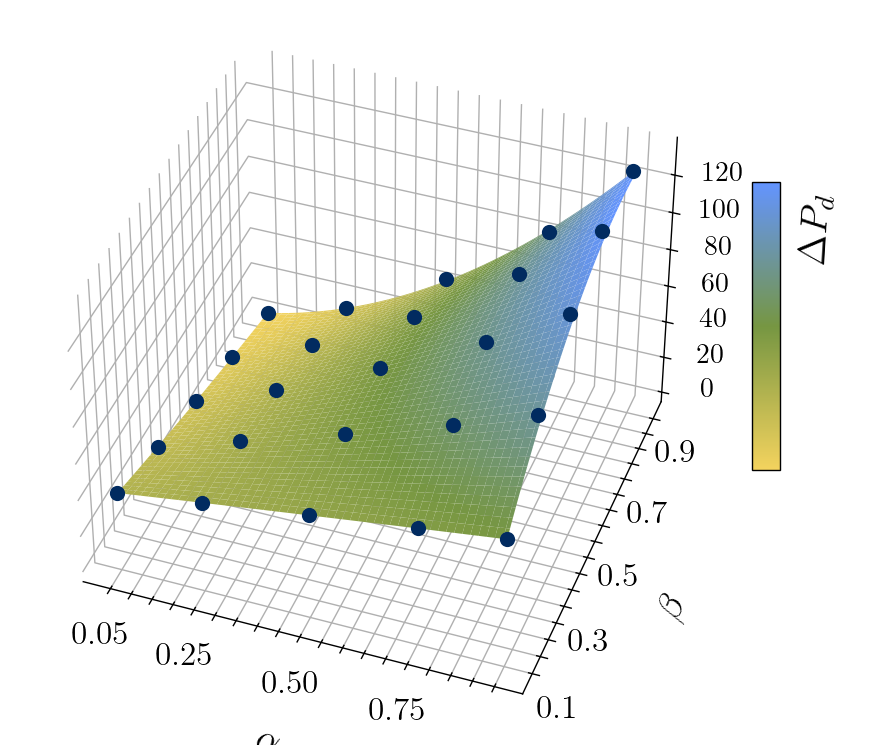

RMSE: 0.8813051757398549


In [31]:
# Assuming abaque_df is predefined
df_fil = abaque_df
Y_name = 'DPc'
letter = Y_name[2:]
X1_name = 'alpha'
X2_name = 'beta'
X_columns = df_fil[[X1_name, X2_name]]

# Generate polynomial features up to the third degree
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_columns)

# Fit the model
model = LinearRegression()
model.fit(X_poly, df_fil[Y_name])

# Coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

grid_size = 100

# Generate a grid for plotting
x1_range = np.linspace(df_fil[X1_name].min(), df_fil[X1_name].max(), grid_size)
x2_range = np.linspace(df_fil[X2_name].min(), df_fil[X2_name].max(), grid_size)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Flatten the grid to apply transformations
X_grid = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T

# Generate polynomial features for the grid
X_grid_poly = poly.transform(X_grid)

# Predict Y values over the grid
y_pred_grid = np.array([[DP_beta(letter, alpha, beta) for alpha in x1_range] for beta in x2_range])

# Plot the surface with matplotlib

fig, ax = plt.subplots(figsize=(rconfig.wcol_in, rconfig.hfig(0.4, unit="in")), facecolor='white', subplot_kw=dict(projection='3d'))

# Surface plot
surf = ax.plot_surface(x1_grid, x2_grid, y_pred_grid, cmap=custom_cmap, edgecolor='none', alpha=1.0)

# Overlay the original data points
ax.scatter(df_fil[X1_name], df_fil[X2_name], df_fil[Y_name], color=rconfig.get_hex_code('blue', 1000), s=20, label='Original Data', zorder=10, depthshade=False)

# Customize axis labels with LaTeX-style labels
ax.set_xlabel(r"$\alpha$", fontsize=14, fontfamily='serif')
ax.set_ylabel(r"$\beta$", fontsize=14, fontfamily='serif')
ax.set_zlabel(r"$\Delta P_d$", fontsize=14, fontfamily='serif',
              labelpad=15)  # Increase the distance between the axis label and the tick labels

# Customize tick labels without changing tick intervals
ax.xaxis.set_tick_params(labelsize=12, pad = -0.3)
ax.yaxis.set_tick_params(labelsize=12, pad = -0.3)
ax.set_xticks([0.05, 0.25, 0.5, 0.75])  # Set specific x-tick values
ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])  # Set specific y-tick values
# ax.set_zticks([])

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# ax.grid(False)

# ax.yaxis._axinfo["grid"].update({"linewidth":1,'color':'red'})
# ax.xaxis.grid(True)
# ax.yaxis.grid(False)
# ax.zaxis.grid(False)
# ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5)
# ax.grid(False, which='both', axis='y')
# ax.grid(False, which='both', axis='z')
# Add grid lines every 0.1 for both x and y axes
# ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
# ax.xaxis.grid(True)
# ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)


# Adjust the view angle

#DPd
# ax.view_init(elev=10, azim=-60)
#DPc
ax.view_init(elev=40, azim=-70)
#DPdc
# ax.view_init(elev=30, azim=-60)

# Color bar for the surface
# DPd
# cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.1, anchor=(-0.4, 0.6))
#DPc
cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.1, anchor=(-0.65, 0.6))
#DPdc
# cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.1, anchor=(-0.4, 0.6))
cbar.set_ticks([])  # Hide ticks on the color bar

# Add color bar with extra space and adjust position
# cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.2, anchor=(1.0, 0.5))
# cbar.set_ticks([])  # Hide ticks on the color bar

# Add an empty annotation at the specified anchor point
fig.text(0.82, 0.5, " ", transform=fig.transFigure)

# Show the plot
plt.show()

# Step 1: Use the model to predict Y values for the original data points
Y_pred = model.predict(X_poly)  # X_poly contains the polynomial features of the original data

# Step 2: Calculate the differences (errors) between predicted and actual Y values
Y_actual = df_fil[Y_name].values  # Actual Y values from the DataFrame

# Step 3: Compute the RMSE
rmse = np.sqrt(mean_squared_error(Y_actual, Y_pred))
print(f"RMSE: {rmse}")


In [16]:
# fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_PL\PL-3D_plot_DPdc', dpi=600)

In [ ]:
temp = 0.5

# Assuming abaque_df is predefined
df_fil = abaque_df
Y_name = 'DPc'
letter = Y_name[2:]
X1_name = 'alpha'
X2_name = 'beta'
X_columns = df_fil[[X1_name, X2_name]]

# Generate polynomial features up to the third degree
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_columns)

# Fit the model
model = LinearRegression()
model.fit(X_poly, df_fil[Y_name])

# Coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

grid_size = 100

# Generate a grid for plotting
x1_range = np.linspace(df_fil[X1_name].min(), df_fil[X1_name].max(), grid_size)
x2_range = np.linspace(df_fil[X2_name].min(), df_fil[X2_name].max(), grid_size)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Flatten the grid to apply transformations
X_grid = np.vstack([x1_grid.ravel(), x2_grid.ravel()]).T

# Generate polynomial features for the grid
X_grid_poly = poly.transform(X_grid)

# Predict Y values over the grid
y_pred_grid = np.array([[DP_beta(letter, alpha, beta) for alpha in x1_range] for beta in x2_range])
# y_pred_grid = model.predict(X_grid_poly).reshape(x1_grid.shape)

# Plot the surface with modified layout
fig = go.Figure()

# Surface trace with custom colorscale
fig.add_trace(go.Surface(
    x=x1_grid, 
    y=x2_grid, 
    z=y_pred_grid, 
    name='Interpolated Surface', 
    colorscale=custom_colorscale, 
    colorbar=dict(len=0.5, x=0.75),  # Smaller colorscale legend
))

# Overlay the original data points
fig.add_trace(go.Scatter3d(
    x=df_fil[X1_name], 
    y=df_fil[X2_name], 
    z=df_fil[Y_name], 
    mode='markers',
    marker=dict(size=5, color=rconfig.get_hex_code('blue', 1000)), 
    name='Original Data'
))

# Update plot layout with larger tick font size and LaTeX-style labels
fig.update_layout(
    # title='3D Surface and Points Plot',
    autosize=False,
    width=temp*rconfig.wcol_px, 
    height=temp*rconfig.hfig(0.3, 'px'),
    margin=dict(l=0, r=0, b=0, t=0),  # Minimize margins
    scene=dict(
        xaxis=dict(
            title=r"α",  # Latex code for alpha in axis label
            backgroundcolor='white',  # White background
            gridcolor='lightgrey',  # Light grey grid lines
            tickfont=dict(family="serif", size=14),  # Larger tick font size
            titlefont=dict(family="serif", size=16),  # Larger title font size
        ),
        yaxis=dict(
            title=r"β",  # Latex code for beta in axis label
            backgroundcolor='white',  # White background
            gridcolor='lightgrey',  # Light grey grid lines
            tickfont=dict(family="serif", size=14),  # Larger tick font size
            titlefont=dict(family="serif", size=18),  # Larger title font size
        ),
        zaxis=dict(
            title=r"ΔPd",  # Latex code for DPd in axis label
            backgroundcolor='white',  # White background
            gridcolor='lightgrey',  # Light grey grid lines
            tickfont=dict(family="serif", size=14),  # Larger tick font size
            titlefont=dict(family="serif", size=18),  # Larger title font size
        ),
    ),
    font=dict(family="serif")  # General font setting for the plot
)

fig.update_layout(scene_camera=dict(eye=dict(x=1.4, y=-1.6, z=0.6)  # Change x, y, z values to set the camera position
                            ))

# Show the plot
fig.show()

# Step 1: Use the model to predict Y values for the original data points
Y_pred = model.predict(X_poly)  # X_poly contains the polynomial features of the original data

# Step 2: Calculate the differences (errors) between predicted and actual Y values
Y_actual = df_fil[Y_name].values  # Actual Y values from the DataFrame

# Step 3: Compute the RMSE
rmse = np.sqrt(mean_squared_error(Y_actual, Y_pred))
print(f"RMSE: {rmse}")

In [27]:
fig.write_image(r'C:\Users\valen\Downloads\test_image.svg', format='svg', scale=20)

In [34]:
fig.write_html(r'C:\Users\valen\Downloads\test.html')

In [18]:
fig.write_image(r'C:\Users\valen\Downloads\test.svg', format='svg', scale=30)

In [19]:
fig.write_image(r'C:\Users\valen\Downloads\test.pdf', format='pdf', scale=1)

In [20]:
fig.write_html(r'C:\Users\valen\Downloads\test.html')

In [ ]:
current_camera = fig.layout.scene.camera
print(current_camera)

In [ ]:
# Define the color codes dictionary as provided
color_codes = {
    "orange": {
        5: "#FEF8F3", 10: "#FDF1E8", 20: "#FAE3D1", 50: "#F3AB88", 
        70: "#EF9E5D", 100: "#E57B17", 150: "#895123"
    },
    "blue": {
        5: "#F7FBFF", 10: "#EFF6FF", 20: "#E0EDFF", 50: "#B1D3FF", 
        70: "#92C1FF", 100: "#6394FF", 150: "#466996"
    },
    "olive": {
        5: "#F8F4E6", 10: "#F1F5EC", 20: "#E4ECD9", 50: "#BACFA0", 
        70: "#9FBE7B", 100: "#769642", 150: "#506538"
    },
    "grey": {
        5: "#F8F8FB", 10: "#F5F5F5", 20: "#EBEBEB", 50: "#C2C2C3", 
        70: "#9A9B9B", 100: "#353738", 150: "#1A1A1A"
    },
    "green": {
        5: "#E0F7F4", 10: "#C7E0E7", 20: "#A8D8D2", 50: "#5CB5AA", 
        70: "#459F97", 100: "#328796", 150: "#145E4C"
    },
    "bordeaux": {
        5: "#FDF0F0", 10: "#F9E9E8", 20: "#F2D3D3", 50: "#E89B9B", 
        70: "#DB6B6B", 100: "#A94442", 150: "#5C1716"
    },
    "yellow": {
        5: "#FFF9E6", 10: "#F7F3D7", 20: "#F1E7B8", 50: "#F4D35E", 
        70: "#E8C64B", 100: "#FAC919", 150: "#D9A008"
    },
    "red": {
        5: "#FDE8E8", 10: "#F7DFD0", 20: "#F3BFB9", 50: "#E89797", 
        70: "#DD6767", 100: "#EF3A3A", 150: "#B52222"
    }
}

# Initialize the plot
fig, ax = plt.subplots(figsize=(20, 15))
y_position = 0  # Initialize the y-position for the labels

# Iterate over each color and its shades
for color_name, shades in color_codes.items():
    for shade, hex_code in shades.items():
        # Draw a rectangle with the specific color
        ax.add_patch(plt.Rectangle((0, y_position), 1, 1, color=hex_code))
        # Display the color name, shade, and hex code next to the rectangle
        ax.text(1.1, y_position + 0.5, f"{color_name} {shade}: {hex_code}", 
                va="center", fontsize=10)
        y_position += 1  # Increment y-position for the next color

# Formatting the plot
ax.set_xlim(0, 2)
ax.set_ylim(0, y_position)
ax.axis('off')  # Hide axes

plt.title("Color Chart with Names and HEX Codes")
plt.show()


In [23]:
import repo_config as rconfig

In [24]:
# df_abaque = pd.read_excel(r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\last ATH\CFD_V4.5_1MPE_woch\AbaqueCFD_1MPE_woch.xlsx")

In [ ]:
DPd(0.1*Q_tot, 0.5)

In [ ]:
DP_beta('d',0.5,0.1)

In [ ]:
Q_tot

In [ ]:
tabl

In [ ]:
plt.scatter(tabl.index, tabl['Pin'])
plt.scatter(tabl.index, tabl['Pout'])
plt.legend()

In [ ]:
plt.scatter(tabl.index, tabl['qx']/(tabl['qx'].sum()/(N*19)))

### Retrouvé dans le code ATH

In [ ]:
# df_abaque = pd.read_excel(r"G:\Drive partagés\Cercle Hard\Notion\PRJ-1088 - CFD pour la caractérisation hydraulique d’un échangeur à mini-canaux\CFD_V4.5_1MPE_woch\AbaqueCFD_1MPE_woch.xlsx")

traces_PL = []
all_residuals = []
all_tabl = []

for N in range(1,4):
    list_tabl = []
    list_residuals = []
    list_PL = []
    for Vdot in df_abaque['Vdot_max'].unique():
        df_fil = df_abaque[df_abaque['Vdot_max'] == Vdot]
        X1_name = 'alpha'
        X2_name = 'beta'
        X_columns = df_fil[[X1_name, X2_name]]
        poly = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly.fit_transform(X_columns)

        model_d = LinearRegression()
        model_d.fit(X_poly, df_fil['DPd'])
        model_c = LinearRegression()
        model_c.fit(X_poly, df_fil['DPc'])
        model_dc = LinearRegression()
        model_dc.fit(X_poly, df_fil['DPdc'])

        # def DPd(Qin, alpha):
        #     point = np.array([[Qin*3600000/Vdot, alpha]])
        #     X_poly = poly.fit_transform(point)
        #     return model_d.predict(X_poly)[0]
        # def DPc(Qin, alpha):
        #     point = np.array([[Qin*3600000/Vdot, alpha]])
        #     X_poly = poly.fit_transform(point)
        #     return model_c.predict(X_poly)[0]
        # def DPdc(Qin, alpha):
        #     point = np.array([[Qin*3600000/Vdot, alpha]])
        #     X_poly = poly.fit_transform(point)
        #     return - model_dc.predict(X_poly)[0]
        DPd, DPc, DPdc = modf2.transfer_func(df_fil, deg_a = 2, deg_q = 2)
        tabl, residuals = modf2.PL_fsolve_MPE(N*19, Vdot/3600000, DPd, DPc, DPdc)
        list_tabl.append(tabl)
        list_PL.append(tabl['Pin'][0])
        list_residuals.append(residuals)

    all_residuals.append(list_residuals)
    all_tabl.append(list_tabl)
    list_Vdot = df_abaque['Vdot_max'].unique()
    traces = []
    for i, tabl in enumerate(list_tabl):
        trace = go.Scatter(x=tabl.index, y=tabl['qx'], name=f'Vdot = {list_Vdot[i]}')
        traces.append(trace)

    layout = go.Layout(title=f'{N} panneau(x)', xaxis=dict(title='MPE'), yaxis=dict(title='qx'))
    fig = go.Figure(data=traces, layout=layout)
    fig.show()

    trace_PL = go.Scatter(x=list_Vdot, y=list_PL, name=f'N = {N} panneaux')
    traces_PL.append(trace_PL)

layout = go.Layout(title='PL vs Vdot', xaxis=dict(title='Vdot'), yaxis=dict(title='PL'))
fig = go.Figure(data=traces_PL, layout=layout)
fig.show()